In [1]:
import os
os.environ['OMP_NUM_THREADS']="1"
from firedrake import *
from firedrake.pyplot import triplot
import math
import operator

In [2]:
nx, ny = 40, 40  # Number of cells in x and y directions.
mesh = UnitSquareMesh(nx, ny, quadrilateral=True)

In [3]:
V = VectorFunctionSpace(mesh, "CG", 2)  # Velocity function space (vector)
W = FunctionSpace(mesh, "CG", 1)  # Pressure function space (scalar)
Q = FunctionSpace(mesh, "CG", 2)  # Temperature function space (scalar)
Z = MixedFunctionSpace([V, W])  # Mixed function space.

z = Function(Z)  # A field over the mixed function space Z.
u, p = split(z)  # Returns symbolic UFL expression for u and p
z.subfunctions[0].rename("Velocity")
z.subfunctions[1].rename("Pressure")

z_test = TestFunction(Z)
u_test, p_test = split(z_test)
q_test = TestFunction(Q)

z_trial = TrialFunction(Z)
u_trial, p_trial = split(z_trial)
q_trial = TrialFunction(Q)

norm = FacetNormal(mesh)

dx = Measure("dx", domain=mesh)
ds = Measure("ds", domain=mesh)
dS = Measure("dS", domain=mesh)

Ra = Constant(1e4)  # Rayleigh number

time = 0.0  # Initial time
delta_t = Constant(1e-3)  # Initial time-step
timesteps = 20000  # Maximum number of timesteps
steady_state_tolerance = 1e-9  # Used to determine if solution has reached a steady state.

X = SpatialCoordinate(mesh)
T = Function(Q, name="Temperature")
T.interpolate((1.0-X[1]) + (0.05*cos(pi*X[0])*sin(pi*X[1])))

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7fd4c8248170>, FiniteElement('Q', quadrilateral, 2), name=None), Mesh(VectorElement(FiniteElement('Q', quadrilateral, 1), dim=2), 0)), 8)

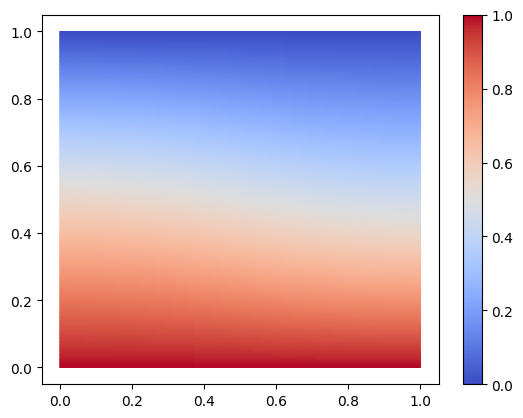

In [4]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots()
collection = tripcolor(T, axes=axes, cmap='coolwarm')
fig.colorbar(collection);

In [5]:
output_file = VTKFile("output.pvd")

## Null spaces

In [6]:
### closed=True, rotational=False
stokes_subspaces = Z.subspaces
V_nullspace = stokes_subspaces[0]
p_nullspace = VectorSpaceBasis(constant=True,comm=Z.mesh().comm)
Z_nullspace = MixedVectorSpaceBasis(Z,[V_nullspace, p_nullspace])

## Energy solver setup

In [7]:
direct_energy_solver_parameters= {
    "mat_type": "aij",
    "snes_type": "ksponly",
    "ksp_type": "preonly",
    "pc_type": "lu",
    "pc_factor_mat_solver_type": "mumps",
    "snes_monitor": None,
}

In [8]:
### Energy solver

###    terms_mapping = {
###        "advection": scalar_eq.advection_term,
###        "diffusion": scalar_eq.diffusion_term,
###        "sink": scalar_eq.sink_term,
###        "source": scalar_eq.source_term,
###    }
###
###    def energy_source(self, u):
###        return self.rho * self.H
###    def linearized_energy_sink(self, u):
###        return 0
### BoussinesqApproximation - rho = 1, H = 0
###            "sink_coeff": self.approximation.linearized_energy_sink(self.u),
###            "source": self.approximation.energy_source(self.u),
###            

def F_advection(test, trial, u, n, dx, ds):
    return trial * div(test * u) * dx - trial * dot(n,u) * test * ds
    #return 0

def F_diffusion(test, trial, dx):
    return -( inner(grad(test),grad(trial)) * dx )
    #return 0

def F_mass( test, trial, dx ):
    return dot(test,trial) * dx

### Time stepping
a = np.array([[0.5]])
b = np.array([1.0])
c = np.array([0.5])
T_old = Function(T)
energy_bcs = [ DirichletBC(Q,0.0,4), DirichletBC(Q,1.0,3) ]
quad_degree = 5
hom_bcs = [bci.__class__(bci.function_space(), 0, bci.sub_domain) for bci in energy_bcs]

tendency = Function(Q) ### k[0]
u_inner = T_old + 0.5*delta_t*tendency
F_energy = F_mass(q_test,tendency,dx) - ( F_advection(q_test,u_inner,u,norm,dx,ds) + F_diffusion(q_test,u_inner,dx))
energy_problem = NonlinearVariationalProblem(F_energy,tendency,bcs=hom_bcs)
energy_solver = NonlinearVariationalSolver(energy_problem, solver_parameters=direct_energy_solver_parameters)
sol_expr = tendency * 0.5*delta_t
final_sol_expr = T_old + tendency * delta_t

In [9]:
u

ListTensor(Indexed(Coefficient(WithGeometry(MixedFunctionSpace(IndexedProxyFunctionSpace(<firedrake.mesh.MeshTopology object at 0x7fd4c8248170>, VectorElement(FiniteElement('Q', quadrilateral, 2), dim=2), name=None, index=0, component=None), IndexedProxyFunctionSpace(<firedrake.mesh.MeshTopology object at 0x7fd4c8248170>, FiniteElement('Q', quadrilateral, 1), name=None, index=1, component=None), name='None_None'), MeshSequence((Mesh(VectorElement(FiniteElement('Q', quadrilateral, 1), dim=2), 0), Mesh(VectorElement(FiniteElement('Q', quadrilateral, 1), dim=2), 0)))), 2), MultiIndex((FixedIndex(0),))), Indexed(Coefficient(WithGeometry(MixedFunctionSpace(IndexedProxyFunctionSpace(<firedrake.mesh.MeshTopology object at 0x7fd4c8248170>, VectorElement(FiniteElement('Q', quadrilateral, 2), dim=2), name=None, index=0, component=None), IndexedProxyFunctionSpace(<firedrake.mesh.MeshTopology object at 0x7fd4c8248170>, FiniteElement('Q', quadrilateral, 1), name=None, index=1, component=None), name

## Stokes solver setup

In [10]:
stokes_solver_parameters = {"snes_type": "ksponly",
    "mat_type": "aij",
    "ksp_type": "preonly",
    "pc_type": "lu",
    "pc_factor_mat_solver_type": "mumps",
#    "snes_monitor": None,
}

In [11]:
### Stokes Solver
stokes_bcs = [ DirichletBC(Z.sub(0).sub(0), 0.0, 1), DirichletBC(Z.sub(0).sub(0), 0.0, 2), DirichletBC(Z.sub(0).sub(1), 0.0, 3), DirichletBC(Z.sub(0).sub(1), 0.0, 4) ]

stress = 2 * sym(grad(u))
source = ( Ra * T ) * as_vector([0,1])

def F_viscosity(test,stress,dx):
    return -( inner(nabla_grad(test),stress ) * dx )

def F_pressure_gradient(test, p, dx):
    return dot(div(test),p) * dx

def F_divergence(test, u, dx):
    return dot(test, div(u)) * dx

def F_momentum_source(test,source,dx):
    return dot(test,source) * dx

F_stokes = -F_momentum_source(u_test,source,dx) - F_pressure_gradient(u_test,p,dx) - F_viscosity(u_test,stress,dx) - F_divergence(p_test,u,dx)

stokes_problem = NonlinearVariationalProblem(F_stokes,z,bcs=stokes_bcs)
stokes_solver = NonlinearVariationalSolver(stokes_problem,solver_parameters=stokes_solver_parameters,nullspace=Z_nullspace,transpose_nullspace=Z_nullspace)

### setup solver
#F_stokes_lin = replace(F_stokes,{z:z_trial})
#a, L = lhs(F_stokes_lin), rhs(F_stokes_lin)

#stokes_problem = LinearVariationalProblem(a,L,z,stokes_bcs,constant_jacobian=True)
#stokes_solver = LinearVariationalSolver(stokes_problem,solver_parameters=stokes_solver_parameters,nullspace=Z_nullspace,transpose_nullspace=Z_nullspace)

In [12]:
for timestep in range(0,timesteps):

    stokes_solver.solve()

    for bci in energy_bcs:
        bci.apply(T)
    T_old.assign(T)
    energy_solver.solve()
    T.assign(T_old + sol_expr)
    T.assign(final_sol_expr)

    maxchange = sqrt(assemble((T - T_old)**2 * dx))
    if maxchange < steady_state_tolerance:
        print("Done?")
        break
    #if timestep == 10:
    #    break

  0 SNES Function norm 8.147131085274e-02
  1 SNES Function norm 9.121866395420e-16
  0 SNES Function norm 1.890788246099e-02
  1 SNES Function norm 1.072556398832e-15
  0 SNES Function norm 2.325339210672e-02
  1 SNES Function norm 1.330386122925e-15
  0 SNES Function norm 2.856892898713e-02
  1 SNES Function norm 1.644331720339e-15
  0 SNES Function norm 3.504126105394e-02
  1 SNES Function norm 2.003618831111e-15
  0 SNES Function norm 4.287650594494e-02
  1 SNES Function norm 2.395354533887e-15
  0 SNES Function norm 5.226492504650e-02
  1 SNES Function norm 2.986084377811e-15
  0 SNES Function norm 6.334508238874e-02
  1 SNES Function norm 3.530504932564e-15
  0 SNES Function norm 7.609692220475e-02
  1 SNES Function norm 4.209530703999e-15
  0 SNES Function norm 9.020287327706e-02
  1 SNES Function norm 4.988022757234e-15
  0 SNES Function norm 1.048395763047e-01
  1 SNES Function norm 6.070915147608e-15
  0 SNES Function norm 1.186115533878e-01
  1 SNES Function norm 6.764596596

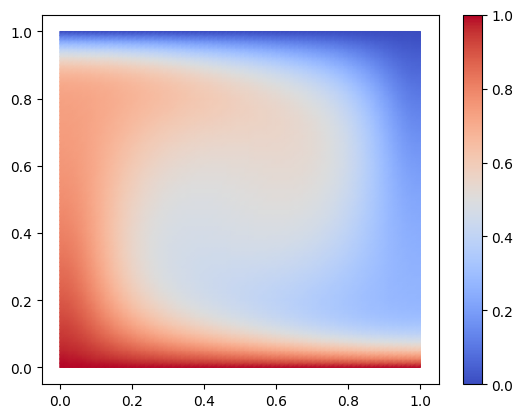

In [13]:
fig, axes = plt.subplots()
collection = tripcolor(assemble(T), axes=axes, cmap='coolwarm')
fig.colorbar(collection);

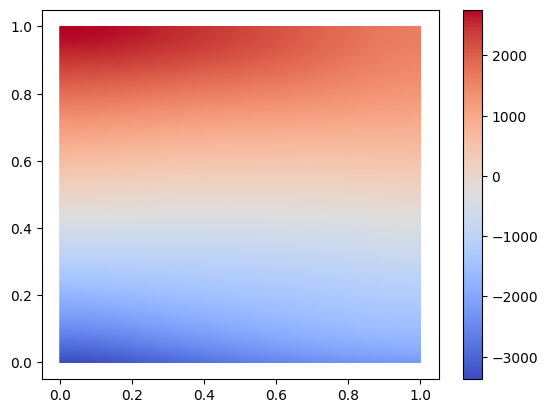

In [14]:
fig, axes = plt.subplots()
collection = tripcolor(z.sub(1), axes=axes, cmap='coolwarm')
fig.colorbar(collection);

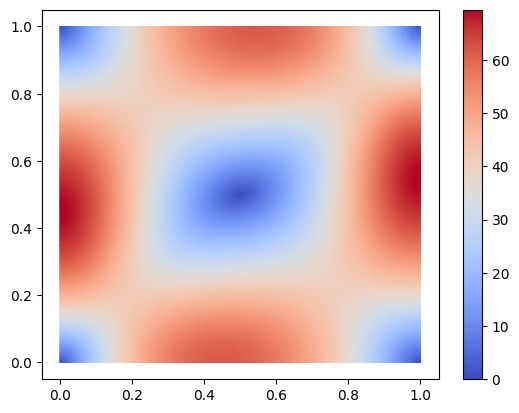

In [15]:
fig, axes = plt.subplots()
collection = tripcolor(z.sub(0), axes=axes, cmap='coolwarm')
fig.colorbar(collection);